<a href="https://colab.research.google.com/github/jchen0000/widsdatathon2025/blob/main/python/Jiaqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

# Data Input

In [53]:
# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Import train categorical data (1213, 10)
train_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
# train_cat.shape
# train_cat.describe()

# Import train quantitative data (1213, 19)
train_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
# train_quant.shape
# train_quant.describe()

# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
# train_sol.shape
# train_sol.describe()

# Merge train datasets on the participant ID  (1213, 28)
combined_train_data = pd.merge(train_cat, train_quant, on='participant_id')
train_with_outcome = pd.merge(combined_train_data, train_sol, on='participant_id')

# Import test categorical data (304, 10)
test_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

# Import test quantitative data (304, 19)
test_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Merge test datasets on the participant ID  (304, 28)
combined_test_data = pd.merge(test_cat, test_quant, on='participant_id')
test_no_id = combined_test_data.drop(columns=['participant_id'])

# Import train MRI data (1213, 19901)
train_mri_filepath = "drive/My Drive/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_mri = pd.read_csv(train_mri_filepath)

# Import test MRI data
test_mri_filepath = "drive/My Drive/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_mri = pd.read_csv(test_mri_filepath)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train fMRI Heatmap

The matrix and heatmap in MRI dataset represent functional connectivity between different regions of the brain for each subject.

The 200x200 matrix represents pairwise connectivity between different brain regions, where 200 is the number of regions.

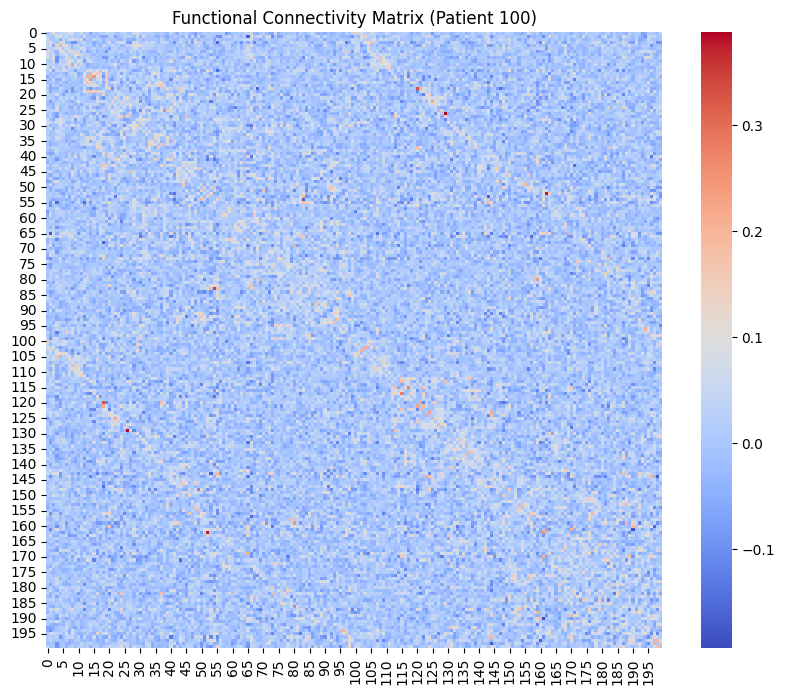

In [54]:
from scipy.spatial.distance import squareform

# Process MRI data

# Columns represent a functional connectivity matrix.
# N = 200 meaning each patient’s connectivity matrix is 200 × 200
N = int((1 + np.sqrt(1 + 8 * 19900)) / 2)

# Remove first line, convert csv file to a functional connectome matrix
train_matrix_data = train_mri.iloc[:, 1:].to_numpy(dtype=float)
# matrix_data.shape (1213, 19900)

# Convert first patient’s vector (19900 values) to full 200x200 matrix
subject_index = 100    # patient n (0, 1212)
subject_vector = train_matrix_data[subject_index]
subject_matrix = squareform(subject_vector)  # Reconstruct NxN matrix

# MRI Heatmap of one patient
plt.figure(figsize=(10, 8))
sns.heatmap(subject_matrix, cmap="coolwarm", square=True)
plt.title(f"Functional Connectivity Matrix (Patient {subject_index})")
plt.show()



In [55]:
# # Train Matrix Dimension Reduction
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Standardize the data before PCA
# scaler = StandardScaler()
# train_mri_scaled = scaler.fit_transform(train_matrix_data)

# # Fit PCA without limiting components
# pca = PCA()
# pca.fit(train_mri_scaled)

# # Cumulative variance explained
# explained_variance = np.cumsum(pca.explained_variance_ratio_)

# # Find the number of components that explain at least 95% variance
# optimal_components = np.argmax(explained_variance >= 0.95) + 1

# print(f"Optimal number of components to retain 95% variance: {optimal_components}")

# # Plot explained variance
# plt.figure(figsize=(10, 6))
# plt.plot(explained_variance, marker='o', linestyle='--', label="Cumulative Variance")
# plt.axhline(y=0.95, color='r', linestyle='-.', label="95% Variance Threshold")
# plt.axvline(x=optimal_components, color='g', linestyle='-.', label=f"{optimal_components} Components")
# plt.xlabel('Number of PCA Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('PCA Explained Variance Plot')
# plt.legend()
# plt.grid()
# plt.show()

# # Now, apply PCA with the optimal number of components
# pca_final = PCA(n_components=optimal_components)
# train_mri_reduced = pca_final.fit_transform(train_mri_scaled)   # (1213, 1103)

# print(f"Reduced MRI feature shape: {train_mri_reduced.shape}")


# Combine Train Metadata and fMRI data

Result: X_train


Clean combined data: replace NA with mean value, separate patient ID.

In [56]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Combine metadata and fMRI into one feature matrix
features = np.hstack([combined_train_data, train_matrix_data])
#features.shape(1213, 19930)

# Check if any elements are strings by checking the type of the array
# if features.dtype == 'O':  # 'O' means object, often used for strings
#     print("There are string values in the matrix.")

# Ensure features data is all numeric
# Replace "NA" with np.nan
features[features == "NA"] = np.nan

# Separate patient ID
patient_ids = features[:, 0]  # Extract patient IDs
features_no_id = features[:, 1:]  # Extract the rest of the feature matrix

# Convert the features_no_id to float (ignoring patient IDs)
features_no_id = features_no_id.astype(float)

# Convert the matrix to float type
features_no_id = features_no_id.astype(float)
# print(features_no_id.dtype) float64

# Impute missing values in features_no_id
# imputer_metadata = SimpleImputer(strategy='mean')  # For numerical columns, use 'mean', 'median', or 'most_frequent'
# combined_metadata_imputed = imputer_metadata.fit_transform(features_no_id)  # (1213, 19927)

# Impute missing values with KNN imputation
imputer_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
combined_metadata_imputed = imputer_metadata.fit_transform(features_no_id)  # (1213, 1130)

# Combine patient IDs back with the processed features_no_id (object)
features = np.hstack([patient_ids.reshape(-1, 1), features_no_id])   # (1213, 1131)

# Test fMRI Heatmap

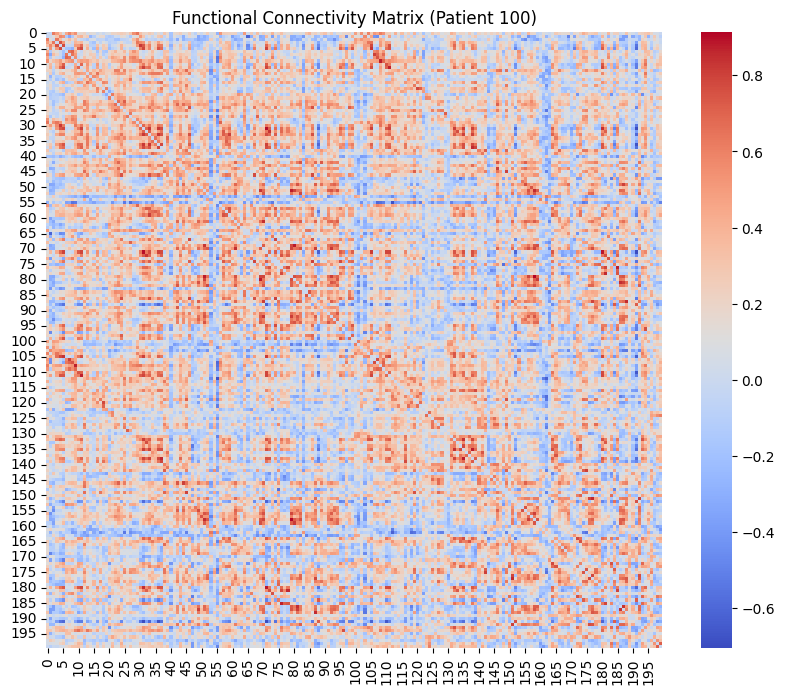

In [57]:
# Remove first line, convert csv file to a functional connectome matrix
test_matrix_data = test_mri.iloc[:, 1:].to_numpy(dtype=float)
# test_matrix_data.shape

# Convert first patient’s vector (19900 values) to full 200x200 matrix
test_subject_index = 100    # patient n (0, 1212)
test_subject_vector = test_matrix_data[test_subject_index]
test_subject_matrix = squareform(test_subject_vector)  # Reconstruct NxN matrix

# MRI Heatmap of one patient
plt.figure(figsize=(10, 8))
sns.heatmap(test_subject_matrix, cmap="coolwarm", square=True)
plt.title(f"Functional Connectivity Matrix (Patient {subject_index})")
plt.show()

In [58]:
# # Test Matrix Dimension Reduction
# test_mri_scaled = scaler.fit_transform(test_matrix_data)
# test_mri_reduced = pca_final.transform(test_mri_scaled)   # (304, 1103)

# Combine Test Metadata and fMRI data

Result: X_test


In [59]:
# Combine metadata and fMRI into one feature matrix
test_features = np.hstack([combined_test_data, test_matrix_data])

# Check if any elements are strings by checking the type of the array
# if features.dtype == 'O':  # 'O' means object, often used for strings
#     print("There are string values in the matrix.")

# Ensure features data is all numeric
# Replace "NA" with np.nan
test_features[test_features == "NA"] = np.nan

# Separate patient ID
test_patient_ids = test_features[:, 0]  # Extract patient IDs
test_features_no_id = test_features[:, 1:]  # Extract the rest of the feature matrix

# Convert the features_no_id to float (ignoring patient IDs)
test_features_no_id = test_features_no_id.astype(float)

# Convert the matrix to float type
test_features_no_id = test_features_no_id.astype(float)
# print(features_no_id.dtype) float64

# Impute missing values in features_no_id
# imputer_test_metadata = SimpleImputer(strategy='mean')  # For numerical columns, use 'mean', 'median', or 'most_frequent'
# combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)  # (304, 19927)

# Impute missing values with KNN imputation
imputer_test_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)  # (304, 284)


# Combine patient IDs back with the processed features_no_id (object)
test_features = np.hstack([test_patient_ids.reshape(-1, 1), test_features_no_id])

# LDA

1.   Fit LDA on training data.
2.   Transform both train and test data into topic distributions.
3.   Use those topic distributions as input features to a classifier (like logistic regression or random forest) to predict ADHD diagnosis or sex.
4.   Evaluate the accuracy of that classifier.


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier

# # Step 1: Train-test split (features only, no labels in LDA training)
# X_train, X_test, y_train, y_test = train_test_split(
#     combined_metadata_imputed,  # metadata + fMRI combined
#     train_sol,     # ADHD diagnosis (or sex)
#     test_size=0.2,
#     random_state=42
# )

# LDA expects non-negative data, shift if needed
combined_metadata_imputed += np.abs(combined_metadata_imputed.min(axis=0))
combined_test_metadata_imputed += np.abs(combined_test_metadata_imputed.min(axis=0))

# (1213, 19927)
X_train = combined_metadata_imputed
# (304, 19927)
X_test = combined_test_metadata_imputed
# (1213, 3)
y_train = train_sol.drop(columns=['participant_id'])

# Fit LDA on training data (features only)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train)

# Get topic distributions for train and test
train_topic_distributions = lda.transform(X_train)
test_topic_distributions = lda.transform(X_test)

# Train classifier on topic distributions to predict ADHD (supervised step)
clf = RandomForestClassifier(random_state=42)
clf.fit(train_topic_distributions, y_train)

RandomForestClassifier(random_state=42)

In [61]:
# Cross-Validation
from sklearn.model_selection import cross_val_score

# Evaluate using cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(clf, train_topic_distributions, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())



Cross-validation scores: [0.54320988 0.51028807 0.41563786 0.31404959 0.05371901]
Mean CV score: 0.36738087950209164


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    combined_metadata_imputed, train_sol.drop(columns=['participant_id']), test_size=0.2, random_state=42)

# Train the LDA and Random Forest model again using the split data
lda.fit(X_train_split)
train_topic_distributions = lda.transform(X_train_split)
test_topic_distributions = lda.transform(X_test_split)

clf.fit(train_topic_distributions, y_train_split)

# Now you can evaluate with the new y_test_split
y_pred = clf.predict(test_topic_distributions)
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Whole sample with Mean Imputation Accuracy: 0.5185185185185185
# Whole sample with KNN Imputation Accuracy: 0.5432098765432098
# 1103 components with KNN Imputation Accuracy: 0.4567901234567901

Accuracy: 0.5432098765432098


In [63]:
X_test_split.shape

(243, 19927)

# Dimension Reduction
PCA

Optimal number of components to retain 95% variance: 1103


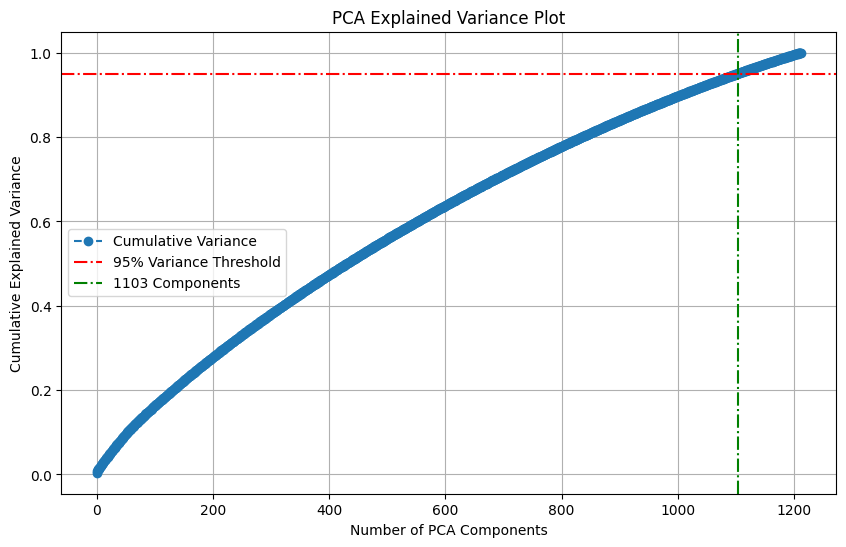

Reduced MRI feature shape: (1213, 1103)


In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data before PCA
scaler = StandardScaler()
train_mri_scaled = scaler.fit_transform(train_matrix_data)

# Fit PCA without limiting components
pca = PCA()
pca.fit(train_mri_scaled)

# Cumulative variance explained
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% variance
optimal_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Optimal number of components to retain 95% variance: {optimal_components}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--', label="Cumulative Variance")
plt.axhline(y=0.95, color='r', linestyle='-.', label="95% Variance Threshold")
plt.axvline(x=optimal_components, color='g', linestyle='-.', label=f"{optimal_components} Components")
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Plot')
plt.legend()
plt.grid()
plt.show()

# Now, apply PCA with the optimal number of components
pca_final = PCA(n_components=optimal_components)
train_mri_reduced = pca_final.fit_transform(train_mri_scaled)

print(f"Reduced MRI feature shape: {train_mri_reduced.shape}")


Train LDA model with 1103 components.
Train LDA Separately for Each Outcome.

In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Extract ADHD_Outcome as one target
train_labels_adhd = train_sol["ADHD_Outcome"].values  # (1213,)

# Extract Sex_F as another target
train_labels_sex = train_sol["Sex_F"].values  # (1213,)


# Split for ADHD outcome
X_train, X_val, y_train, y_val = train_test_split(train_mri_reduced, train_labels_adhd, test_size=0.2, stratify=train_labels_adhd, random_state=42)

# Train LDA Model for ADHD
lda_adhd = LinearDiscriminantAnalysis()
lda_adhd.fit(X_train, y_train)

# Predict & Evaluate
y_val_pred = lda_adhd.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"LDA Accuracy for ADHD Outcome: {accuracy:.4f}")

# LDA Accuracy for ADHD Outcome: 0.4897

# Split for Sex_F outcome
X_train, X_val, y_train, y_val = train_test_split(train_mri_reduced, train_labels_sex, test_size=0.2, stratify=train_labels_sex, random_state=42)

# Train LDA Model for Sex_F
lda_sex = LinearDiscriminantAnalysis()
lda_sex.fit(X_train, y_train)

# Predict & Evaluate
y_val_pred = lda_sex.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"LDA Accuracy for Sex_F Outcome: {accuracy:.4f}")

# LDA Accuracy for Sex_F Outcome: 0.5144

LDA Accuracy for ADHD Outcome: 0.4897
LDA Accuracy for Sex_F Outcome: 0.5144


# Neural Network